In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'paper-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from paper-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(9700, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-resnet50-Adam-2000epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    predict = Dense(num_classes, activation='softmax', name='predictions')(top_input)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 7760 samples, validate on 1940 samples
Epoch 1/2000
7760/7760 [==============================] - 0s - loss: 0.9389 - acc: 0.4870 - val_loss: 0.8043 - val_acc: 0.5649
Epoch 2/2000
7760/7760 [==============================] - 0s - loss: 0.8112 - acc: 0.5617 - val_loss: 0.7066 - val_acc: 0.6088
Epoch 3/2000
7760/7760 [==============================] - 0s - loss: 0.7067 - acc: 0.6115 - val_loss: 0.6396 - val_acc: 0.6588
Epoch 4/2000
7760/7760 [==============================] - 0s - loss: 0.6364 - acc: 0.6640 - val_loss: 0.5777 - val_acc: 0.6995
Epoch 5/2000
7760/7760 [==============================] - 0s - loss: 0.5734 - acc: 0.7116 - val_loss: 0.5324 - val_acc: 0.7325
Epoch 6/2000
7760/7760 [==============================] - 0s - loss: 0.5278 - acc: 0.7436 - val_loss: 0.4985 - val_acc: 0.7557
Epoch 7/2000
7760/7760 [==============================] - 0s - loss: 0.4937 - acc: 0.7665 - val_loss: 0.4715 - val_acc: 0.7768
Epoch 8/2000
7760/7760 [==============================] - 0s - 

7760/7760 [==============================] - 0s - loss: 0.1993 - acc: 0.9211 - val_loss: 0.2360 - val_acc: 0.9021
Epoch 65/2000
7760/7760 [==============================] - 0s - loss: 0.1981 - acc: 0.9218 - val_loss: 0.2351 - val_acc: 0.9031
Epoch 66/2000
7760/7760 [==============================] - 0s - loss: 0.1969 - acc: 0.9223 - val_loss: 0.2343 - val_acc: 0.9041
Epoch 67/2000
7760/7760 [==============================] - 0s - loss: 0.1957 - acc: 0.9228 - val_loss: 0.2335 - val_acc: 0.9046
Epoch 68/2000
7760/7760 [==============================] - 0s - loss: 0.1946 - acc: 0.9233 - val_loss: 0.2327 - val_acc: 0.9046
Epoch 69/2000
7760/7760 [==============================] - 0s - loss: 0.1934 - acc: 0.9238 - val_loss: 0.2319 - val_acc: 0.9057
Epoch 70/2000
7760/7760 [==============================] - 0s - loss: 0.1923 - acc: 0.9242 - val_loss: 0.2312 - val_acc: 0.9052
Epoch 71/2000
7760/7760 [==============================] - 0s - loss: 0.1912 - acc: 0.9251 - val_loss: 0.2304 - val_ac

7760/7760 [==============================] - 0s - loss: 0.1488 - acc: 0.9468 - val_loss: 0.2071 - val_acc: 0.9196
Epoch 128/2000
7760/7760 [==============================] - 0s - loss: 0.1482 - acc: 0.9466 - val_loss: 0.2069 - val_acc: 0.9196
Epoch 129/2000
7760/7760 [==============================] - 0s - loss: 0.1477 - acc: 0.9468 - val_loss: 0.2066 - val_acc: 0.9196
Epoch 130/2000
7760/7760 [==============================] - 0s - loss: 0.1472 - acc: 0.9470 - val_loss: 0.2064 - val_acc: 0.9196
Epoch 131/2000
7760/7760 [==============================] - 0s - loss: 0.1466 - acc: 0.9472 - val_loss: 0.2062 - val_acc: 0.9196
Epoch 132/2000
7760/7760 [==============================] - 0s - loss: 0.1461 - acc: 0.9476 - val_loss: 0.2060 - val_acc: 0.9201
Epoch 133/2000
7760/7760 [==============================] - 0s - loss: 0.1456 - acc: 0.9486 - val_loss: 0.2058 - val_acc: 0.9206
Epoch 134/2000
7760/7760 [==============================] - 0s - loss: 0.1451 - acc: 0.9488 - val_loss: 0.2056 -

7760/7760 [==============================] - 0s - loss: 0.1220 - acc: 0.9590 - val_loss: 0.1991 - val_acc: 0.9237
Epoch 191/2000
7760/7760 [==============================] - 0s - loss: 0.1216 - acc: 0.9593 - val_loss: 0.1991 - val_acc: 0.9237
Epoch 192/2000
7760/7760 [==============================] - 0s - loss: 0.1213 - acc: 0.9597 - val_loss: 0.1990 - val_acc: 0.9237
Epoch 193/2000
7760/7760 [==============================] - 0s - loss: 0.1210 - acc: 0.9599 - val_loss: 0.1990 - val_acc: 0.9237
Epoch 194/2000
7760/7760 [==============================] - 0s - loss: 0.1206 - acc: 0.9601 - val_loss: 0.1989 - val_acc: 0.9237
Epoch 195/2000
7760/7760 [==============================] - 0s - loss: 0.1203 - acc: 0.9603 - val_loss: 0.1989 - val_acc: 0.9237
Epoch 196/2000
7760/7760 [==============================] - 0s - loss: 0.1200 - acc: 0.9603 - val_loss: 0.1988 - val_acc: 0.9237
Epoch 197/2000
7760/7760 [==============================] - 0s - loss: 0.1197 - acc: 0.9606 - val_loss: 0.1988 -

7760/7760 [==============================] - 0s - loss: 0.1043 - acc: 0.9659 - val_loss: 0.1980 - val_acc: 0.9278
Epoch 254/2000
7760/7760 [==============================] - 0s - loss: 0.1041 - acc: 0.9659 - val_loss: 0.1980 - val_acc: 0.9278
Epoch 255/2000
7760/7760 [==============================] - 0s - loss: 0.1039 - acc: 0.9659 - val_loss: 0.1981 - val_acc: 0.9278
Epoch 256/2000
7760/7760 [==============================] - 0s - loss: 0.1036 - acc: 0.9662 - val_loss: 0.1981 - val_acc: 0.9278
Epoch 257/2000
7760/7760 [==============================] - 0s - loss: 0.1034 - acc: 0.9666 - val_loss: 0.1981 - val_acc: 0.9278
Epoch 258/2000
7760/7760 [==============================] - 0s - loss: 0.1032 - acc: 0.9668 - val_loss: 0.1981 - val_acc: 0.9278
Epoch 00257: early stopping
[0] Test acurracy: 0.9278
Train on 7760 samples, validate on 1940 samples
Epoch 1/2000
7760/7760 [==============================] - 0s - loss: 1.0900 - acc: 0.4161 - val_loss: 0.9782 - val_acc: 0.4814
Epoch 2/2000

7760/7760 [==============================] - 0s - loss: 0.2126 - acc: 0.9153 - val_loss: 0.2564 - val_acc: 0.8933
Epoch 59/2000
7760/7760 [==============================] - 0s - loss: 0.2112 - acc: 0.9161 - val_loss: 0.2556 - val_acc: 0.8928
Epoch 60/2000
7760/7760 [==============================] - 0s - loss: 0.2098 - acc: 0.9165 - val_loss: 0.2549 - val_acc: 0.8928
Epoch 61/2000
7760/7760 [==============================] - 0s - loss: 0.2084 - acc: 0.9169 - val_loss: 0.2541 - val_acc: 0.8938
Epoch 62/2000
7760/7760 [==============================] - 0s - loss: 0.2071 - acc: 0.9175 - val_loss: 0.2532 - val_acc: 0.8938
Epoch 63/2000
7760/7760 [==============================] - 0s - loss: 0.2058 - acc: 0.9179 - val_loss: 0.2523 - val_acc: 0.8959
Epoch 64/2000
7760/7760 [==============================] - 0s - loss: 0.2045 - acc: 0.9193 - val_loss: 0.2515 - val_acc: 0.8964
Epoch 65/2000
7760/7760 [==============================] - 0s - loss: 0.2033 - acc: 0.9202 - val_loss: 0.2507 - val_ac

7760/7760 [==============================] - 0s - loss: 0.1577 - acc: 0.9432 - val_loss: 0.2279 - val_acc: 0.9082
Epoch 122/2000
7760/7760 [==============================] - 0s - loss: 0.1571 - acc: 0.9433 - val_loss: 0.2276 - val_acc: 0.9082
Epoch 123/2000
7760/7760 [==============================] - 0s - loss: 0.1566 - acc: 0.9433 - val_loss: 0.2274 - val_acc: 0.9088
Epoch 124/2000
7760/7760 [==============================] - 0s - loss: 0.1560 - acc: 0.9438 - val_loss: 0.2272 - val_acc: 0.9093
Epoch 125/2000
7760/7760 [==============================] - 0s - loss: 0.1554 - acc: 0.9439 - val_loss: 0.2270 - val_acc: 0.9093
Epoch 126/2000
7760/7760 [==============================] - 0s - loss: 0.1549 - acc: 0.9445 - val_loss: 0.2268 - val_acc: 0.9088
Epoch 127/2000
7760/7760 [==============================] - 0s - loss: 0.1544 - acc: 0.9448 - val_loss: 0.2266 - val_acc: 0.9088
Epoch 128/2000
7760/7760 [==============================] - 0s - loss: 0.1538 - acc: 0.9450 - val_loss: 0.2264 -

7760/7760 [==============================] - 0s - loss: 0.1295 - acc: 0.9557 - val_loss: 0.2194 - val_acc: 0.9113
Epoch 185/2000
7760/7760 [==============================] - 0s - loss: 0.1291 - acc: 0.9555 - val_loss: 0.2193 - val_acc: 0.9113
Epoch 186/2000
7760/7760 [==============================] - 0s - loss: 0.1288 - acc: 0.9558 - val_loss: 0.2193 - val_acc: 0.9113
Epoch 187/2000
7760/7760 [==============================] - 0s - loss: 0.1284 - acc: 0.9562 - val_loss: 0.2192 - val_acc: 0.9113
Epoch 188/2000
7760/7760 [==============================] - 0s - loss: 0.1281 - acc: 0.9563 - val_loss: 0.2191 - val_acc: 0.9113
Epoch 189/2000
7760/7760 [==============================] - 0s - loss: 0.1277 - acc: 0.9567 - val_loss: 0.2191 - val_acc: 0.9113
Epoch 190/2000
7760/7760 [==============================] - 0s - loss: 0.1274 - acc: 0.9570 - val_loss: 0.2190 - val_acc: 0.9113
Epoch 191/2000
7760/7760 [==============================] - 0s - loss: 0.1271 - acc: 0.9572 - val_loss: 0.2190 -

7760/7760 [==============================] - 0s - loss: 0.1108 - acc: 0.9651 - val_loss: 0.2180 - val_acc: 0.9160
Epoch 248/2000
7760/7760 [==============================] - 0s - loss: 0.1106 - acc: 0.9651 - val_loss: 0.2180 - val_acc: 0.9160
Epoch 249/2000
7760/7760 [==============================] - 0s - loss: 0.1104 - acc: 0.9652 - val_loss: 0.2181 - val_acc: 0.9160
Epoch 250/2000
7760/7760 [==============================] - 0s - loss: 0.1101 - acc: 0.9652 - val_loss: 0.2181 - val_acc: 0.9165
Epoch 251/2000
7760/7760 [==============================] - 0s - loss: 0.1099 - acc: 0.9653 - val_loss: 0.2181 - val_acc: 0.9165
Epoch 252/2000
7760/7760 [==============================] - 0s - loss: 0.1096 - acc: 0.9655 - val_loss: 0.2181 - val_acc: 0.9165
Epoch 253/2000
7760/7760 [==============================] - 0s - loss: 0.1094 - acc: 0.9657 - val_loss: 0.2181 - val_acc: 0.9165
Epoch 254/2000
7760/7760 [==============================] - 0s - loss: 0.1091 - acc: 0.9660 - val_loss: 0.2181 -

7760/7760 [==============================] - 0s - loss: 0.1981 - acc: 0.9260 - val_loss: 0.2167 - val_acc: 0.9129
Epoch 56/2000
7760/7760 [==============================] - 0s - loss: 0.1967 - acc: 0.9271 - val_loss: 0.2159 - val_acc: 0.9129
Epoch 57/2000
7760/7760 [==============================] - 0s - loss: 0.1953 - acc: 0.9281 - val_loss: 0.2152 - val_acc: 0.9134
Epoch 58/2000
7760/7760 [==============================] - 0s - loss: 0.1940 - acc: 0.9286 - val_loss: 0.2145 - val_acc: 0.9134
Epoch 59/2000
7760/7760 [==============================] - 0s - loss: 0.1927 - acc: 0.9289 - val_loss: 0.2138 - val_acc: 0.9139
Epoch 60/2000
7760/7760 [==============================] - 0s - loss: 0.1914 - acc: 0.9291 - val_loss: 0.2131 - val_acc: 0.9144
Epoch 61/2000
7760/7760 [==============================] - 0s - loss: 0.1901 - acc: 0.9294 - val_loss: 0.2125 - val_acc: 0.9149
Epoch 62/2000
7760/7760 [==============================] - 0s - loss: 0.1889 - acc: 0.9300 - val_loss: 0.2119 - val_ac

7760/7760 [==============================] - 0s - loss: 0.1436 - acc: 0.9503 - val_loss: 0.1893 - val_acc: 0.9222
Epoch 119/2000
7760/7760 [==============================] - 0s - loss: 0.1431 - acc: 0.9505 - val_loss: 0.1891 - val_acc: 0.9222
Epoch 120/2000
7760/7760 [==============================] - 0s - loss: 0.1425 - acc: 0.9506 - val_loss: 0.1889 - val_acc: 0.9222
Epoch 121/2000
7760/7760 [==============================] - 0s - loss: 0.1420 - acc: 0.9509 - val_loss: 0.1887 - val_acc: 0.9222
Epoch 122/2000
7760/7760 [==============================] - 0s - loss: 0.1414 - acc: 0.9512 - val_loss: 0.1885 - val_acc: 0.9222
Epoch 123/2000
7760/7760 [==============================] - 0s - loss: 0.1409 - acc: 0.9514 - val_loss: 0.1883 - val_acc: 0.9222
Epoch 124/2000
7760/7760 [==============================] - 0s - loss: 0.1404 - acc: 0.9518 - val_loss: 0.1881 - val_acc: 0.9222
Epoch 125/2000
7760/7760 [==============================] - 0s - loss: 0.1399 - acc: 0.9522 - val_loss: 0.1879 -

7760/7760 [==============================] - 0s - loss: 0.1165 - acc: 0.9626 - val_loss: 0.1818 - val_acc: 0.9273
Epoch 182/2000
7760/7760 [==============================] - 0s - loss: 0.1162 - acc: 0.9628 - val_loss: 0.1818 - val_acc: 0.9273
Epoch 183/2000
7760/7760 [==============================] - 0s - loss: 0.1159 - acc: 0.9629 - val_loss: 0.1818 - val_acc: 0.9273
Epoch 184/2000
7760/7760 [==============================] - 0s - loss: 0.1155 - acc: 0.9629 - val_loss: 0.1817 - val_acc: 0.9273
Epoch 185/2000
7760/7760 [==============================] - 0s - loss: 0.1152 - acc: 0.9630 - val_loss: 0.1817 - val_acc: 0.9273
Epoch 186/2000
7760/7760 [==============================] - 0s - loss: 0.1149 - acc: 0.9631 - val_loss: 0.1817 - val_acc: 0.9273
Epoch 187/2000
7760/7760 [==============================] - 0s - loss: 0.1146 - acc: 0.9633 - val_loss: 0.1816 - val_acc: 0.9273
Epoch 188/2000
7760/7760 [==============================] - 0s - loss: 0.1142 - acc: 0.9635 - val_loss: 0.1816 -

7760/7760 [==============================] - 0s - loss: 0.4322 - acc: 0.8068 - val_loss: 0.4400 - val_acc: 0.8026
Epoch 20/2000
7760/7760 [==============================] - 0s - loss: 0.4250 - acc: 0.8126 - val_loss: 0.4307 - val_acc: 0.8062
Epoch 21/2000
7760/7760 [==============================] - 0s - loss: 0.4148 - acc: 0.8180 - val_loss: 0.4181 - val_acc: 0.8072
Epoch 22/2000
7760/7760 [==============================] - 0s - loss: 0.4027 - acc: 0.8209 - val_loss: 0.4057 - val_acc: 0.8119
Epoch 23/2000
7760/7760 [==============================] - 0s - loss: 0.3916 - acc: 0.8236 - val_loss: 0.3962 - val_acc: 0.8211
Epoch 24/2000
7760/7760 [==============================] - 0s - loss: 0.3835 - acc: 0.8269 - val_loss: 0.3898 - val_acc: 0.8294
Epoch 25/2000
7760/7760 [==============================] - 0s - loss: 0.3778 - acc: 0.8291 - val_loss: 0.3846 - val_acc: 0.8351
Epoch 26/2000
7760/7760 [==============================] - 0s - loss: 0.3725 - acc: 0.8323 - val_loss: 0.3793 - val_ac

7760/7760 [==============================] - 0s - loss: 0.2301 - acc: 0.9057 - val_loss: 0.2763 - val_acc: 0.8907
Epoch 84/2000
7760/7760 [==============================] - 0s - loss: 0.2291 - acc: 0.9057 - val_loss: 0.2755 - val_acc: 0.8912
Epoch 85/2000
7760/7760 [==============================] - 0s - loss: 0.2281 - acc: 0.9064 - val_loss: 0.2748 - val_acc: 0.8918
Epoch 86/2000
7760/7760 [==============================] - 0s - loss: 0.2271 - acc: 0.9073 - val_loss: 0.2741 - val_acc: 0.8923
Epoch 87/2000
7760/7760 [==============================] - 0s - loss: 0.2261 - acc: 0.9077 - val_loss: 0.2735 - val_acc: 0.8912
Epoch 88/2000
7760/7760 [==============================] - 0s - loss: 0.2252 - acc: 0.9077 - val_loss: 0.2729 - val_acc: 0.8928
Epoch 89/2000
7760/7760 [==============================] - 0s - loss: 0.2242 - acc: 0.9082 - val_loss: 0.2724 - val_acc: 0.8938
Epoch 90/2000
7760/7760 [==============================] - 0s - loss: 0.2233 - acc: 0.9086 - val_loss: 0.2718 - val_ac

7760/7760 [==============================] - 0s - loss: 0.1851 - acc: 0.9280 - val_loss: 0.2478 - val_acc: 0.9015
Epoch 147/2000
7760/7760 [==============================] - 0s - loss: 0.1846 - acc: 0.9285 - val_loss: 0.2475 - val_acc: 0.9021
Epoch 148/2000
7760/7760 [==============================] - 0s - loss: 0.1841 - acc: 0.9286 - val_loss: 0.2472 - val_acc: 0.9026
Epoch 149/2000
7760/7760 [==============================] - 0s - loss: 0.1836 - acc: 0.9291 - val_loss: 0.2469 - val_acc: 0.9026
Epoch 150/2000
7760/7760 [==============================] - 0s - loss: 0.1831 - acc: 0.9294 - val_loss: 0.2466 - val_acc: 0.9026
Epoch 151/2000
7760/7760 [==============================] - 0s - loss: 0.1826 - acc: 0.9296 - val_loss: 0.2463 - val_acc: 0.9026
Epoch 152/2000
7760/7760 [==============================] - 0s - loss: 0.1821 - acc: 0.9298 - val_loss: 0.2460 - val_acc: 0.9026
Epoch 153/2000
7760/7760 [==============================] - 0s - loss: 0.1816 - acc: 0.9300 - val_loss: 0.2457 -

7760/7760 [==============================] - 0s - loss: 0.1587 - acc: 0.9416 - val_loss: 0.2336 - val_acc: 0.9057
Epoch 210/2000
7760/7760 [==============================] - 0s - loss: 0.1584 - acc: 0.9419 - val_loss: 0.2334 - val_acc: 0.9057
Epoch 211/2000
7760/7760 [==============================] - 0s - loss: 0.1580 - acc: 0.9424 - val_loss: 0.2332 - val_acc: 0.9062
Epoch 212/2000
7760/7760 [==============================] - 0s - loss: 0.1577 - acc: 0.9425 - val_loss: 0.2331 - val_acc: 0.9062
Epoch 213/2000
7760/7760 [==============================] - 0s - loss: 0.1573 - acc: 0.9427 - val_loss: 0.2329 - val_acc: 0.9057
Epoch 214/2000
7760/7760 [==============================] - 0s - loss: 0.1570 - acc: 0.9429 - val_loss: 0.2328 - val_acc: 0.9062
Epoch 215/2000
7760/7760 [==============================] - 0s - loss: 0.1567 - acc: 0.9433 - val_loss: 0.2326 - val_acc: 0.9062
Epoch 216/2000
7760/7760 [==============================] - 0s - loss: 0.1563 - acc: 0.9434 - val_loss: 0.2324 -

7760/7760 [==============================] - 0s - loss: 0.1402 - acc: 0.9515 - val_loss: 0.2256 - val_acc: 0.9082
Epoch 273/2000
7760/7760 [==============================] - 0s - loss: 0.1399 - acc: 0.9517 - val_loss: 0.2255 - val_acc: 0.9088
Epoch 274/2000
7760/7760 [==============================] - 0s - loss: 0.1397 - acc: 0.9518 - val_loss: 0.2255 - val_acc: 0.9088
Epoch 275/2000
7760/7760 [==============================] - 0s - loss: 0.1394 - acc: 0.9519 - val_loss: 0.2254 - val_acc: 0.9088
Epoch 276/2000
7760/7760 [==============================] - 0s - loss: 0.1392 - acc: 0.9523 - val_loss: 0.2253 - val_acc: 0.9082
Epoch 277/2000
7760/7760 [==============================] - 0s - loss: 0.1389 - acc: 0.9523 - val_loss: 0.2252 - val_acc: 0.9082
Epoch 278/2000
7760/7760 [==============================] - 0s - loss: 0.1387 - acc: 0.9523 - val_loss: 0.2251 - val_acc: 0.9082
Epoch 279/2000
7760/7760 [==============================] - 0s - loss: 0.1384 - acc: 0.9523 - val_loss: 0.2250 -

7760/7760 [==============================] - 0s - loss: 0.1261 - acc: 0.9577 - val_loss: 0.2214 - val_acc: 0.9098
Epoch 336/2000
7760/7760 [==============================] - 0s - loss: 0.1259 - acc: 0.9577 - val_loss: 0.2213 - val_acc: 0.9098
Epoch 337/2000
7760/7760 [==============================] - 0s - loss: 0.1257 - acc: 0.9579 - val_loss: 0.2213 - val_acc: 0.9098
Epoch 338/2000
7760/7760 [==============================] - 0s - loss: 0.1255 - acc: 0.9579 - val_loss: 0.2212 - val_acc: 0.9098
Epoch 339/2000
7760/7760 [==============================] - 0s - loss: 0.1253 - acc: 0.9581 - val_loss: 0.2212 - val_acc: 0.9098
Epoch 340/2000
7760/7760 [==============================] - 0s - loss: 0.1251 - acc: 0.9582 - val_loss: 0.2211 - val_acc: 0.9108
Epoch 341/2000
7760/7760 [==============================] - 0s - loss: 0.1249 - acc: 0.9584 - val_loss: 0.2211 - val_acc: 0.9108
Epoch 342/2000
7760/7760 [==============================] - 0s - loss: 0.1247 - acc: 0.9585 - val_loss: 0.2210 -

7760/7760 [==============================] - 0s - loss: 0.1148 - acc: 0.9630 - val_loss: 0.2194 - val_acc: 0.9129
Epoch 399/2000
7760/7760 [==============================] - 0s - loss: 0.1147 - acc: 0.9631 - val_loss: 0.2194 - val_acc: 0.9129
Epoch 400/2000
7760/7760 [==============================] - 0s - loss: 0.1145 - acc: 0.9633 - val_loss: 0.2194 - val_acc: 0.9129
Epoch 401/2000
7760/7760 [==============================] - 0s - loss: 0.1144 - acc: 0.9633 - val_loss: 0.2194 - val_acc: 0.9129
Epoch 402/2000
7760/7760 [==============================] - 0s - loss: 0.1142 - acc: 0.9633 - val_loss: 0.2193 - val_acc: 0.9129
Epoch 403/2000
7760/7760 [==============================] - 0s - loss: 0.1140 - acc: 0.9634 - val_loss: 0.2193 - val_acc: 0.9129
Epoch 404/2000
7760/7760 [==============================] - 0s - loss: 0.1139 - acc: 0.9635 - val_loss: 0.2193 - val_acc: 0.9129
Epoch 405/2000
7760/7760 [==============================] - 0s - loss: 0.1137 - acc: 0.9637 - val_loss: 0.2193 -

7760/7760 [==============================] - 0s - loss: 0.1056 - acc: 0.9671 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 462/2000
7760/7760 [==============================] - 0s - loss: 0.1054 - acc: 0.9674 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 463/2000
7760/7760 [==============================] - 0s - loss: 0.1053 - acc: 0.9674 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 464/2000
7760/7760 [==============================] - 0s - loss: 0.1052 - acc: 0.9675 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 465/2000
7760/7760 [==============================] - 0s - loss: 0.1050 - acc: 0.9675 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 466/2000
7760/7760 [==============================] - 0s - loss: 0.1049 - acc: 0.9677 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 467/2000
7760/7760 [==============================] - 0s - loss: 0.1048 - acc: 0.9677 - val_loss: 0.2191 - val_acc: 0.9129
Epoch 468/2000
7760/7760 [==============================] - 0s - loss: 0.1046 - acc: 0.9679 - val_loss: 0.2191 -

7760/7760 [==============================] - 0s - loss: 0.2400 - acc: 0.9028 - val_loss: 0.2722 - val_acc: 0.8840
Epoch 57/2000
7760/7760 [==============================] - 0s - loss: 0.2384 - acc: 0.9045 - val_loss: 0.2712 - val_acc: 0.8851
Epoch 58/2000
7760/7760 [==============================] - 0s - loss: 0.2369 - acc: 0.9055 - val_loss: 0.2703 - val_acc: 0.8871
Epoch 59/2000
7760/7760 [==============================] - 0s - loss: 0.2355 - acc: 0.9067 - val_loss: 0.2693 - val_acc: 0.8876
Epoch 60/2000
7760/7760 [==============================] - 0s - loss: 0.2340 - acc: 0.9075 - val_loss: 0.2682 - val_acc: 0.8897
Epoch 61/2000
7760/7760 [==============================] - 0s - loss: 0.2327 - acc: 0.9081 - val_loss: 0.2669 - val_acc: 0.8892
Epoch 62/2000
7760/7760 [==============================] - 0s - loss: 0.2313 - acc: 0.9088 - val_loss: 0.2657 - val_acc: 0.8897
Epoch 63/2000
7760/7760 [==============================] - 0s - loss: 0.2299 - acc: 0.9097 - val_loss: 0.2644 - val_ac

7760/7760 [==============================] - 0s - loss: 0.1807 - acc: 0.9330 - val_loss: 0.2290 - val_acc: 0.9021
Epoch 120/2000
7760/7760 [==============================] - 0s - loss: 0.1801 - acc: 0.9332 - val_loss: 0.2286 - val_acc: 0.9026
Epoch 121/2000
7760/7760 [==============================] - 0s - loss: 0.1795 - acc: 0.9336 - val_loss: 0.2282 - val_acc: 0.9026
Epoch 122/2000
7760/7760 [==============================] - 0s - loss: 0.1789 - acc: 0.9340 - val_loss: 0.2278 - val_acc: 0.9031
Epoch 123/2000
7760/7760 [==============================] - 0s - loss: 0.1783 - acc: 0.9343 - val_loss: 0.2274 - val_acc: 0.9031
Epoch 124/2000
7760/7760 [==============================] - 0s - loss: 0.1777 - acc: 0.9345 - val_loss: 0.2271 - val_acc: 0.9031
Epoch 125/2000
7760/7760 [==============================] - 0s - loss: 0.1771 - acc: 0.9344 - val_loss: 0.2267 - val_acc: 0.9031
Epoch 126/2000
7760/7760 [==============================] - 0s - loss: 0.1765 - acc: 0.9349 - val_loss: 0.2263 -

7760/7760 [==============================] - 0s - loss: 0.1499 - acc: 0.9474 - val_loss: 0.2115 - val_acc: 0.9108
Epoch 183/2000
7760/7760 [==============================] - 0s - loss: 0.1495 - acc: 0.9477 - val_loss: 0.2113 - val_acc: 0.9108
Epoch 184/2000
7760/7760 [==============================] - 0s - loss: 0.1491 - acc: 0.9477 - val_loss: 0.2111 - val_acc: 0.9108
Epoch 185/2000
7760/7760 [==============================] - 0s - loss: 0.1487 - acc: 0.9477 - val_loss: 0.2109 - val_acc: 0.9108
Epoch 186/2000
7760/7760 [==============================] - 0s - loss: 0.1483 - acc: 0.9479 - val_loss: 0.2107 - val_acc: 0.9108
Epoch 187/2000
7760/7760 [==============================] - 0s - loss: 0.1480 - acc: 0.9481 - val_loss: 0.2106 - val_acc: 0.9108
Epoch 188/2000
7760/7760 [==============================] - 0s - loss: 0.1476 - acc: 0.9483 - val_loss: 0.2104 - val_acc: 0.9108
Epoch 189/2000
7760/7760 [==============================] - 0s - loss: 0.1472 - acc: 0.9486 - val_loss: 0.2102 -

7760/7760 [==============================] - 0s - loss: 0.1294 - acc: 0.9570 - val_loss: 0.2030 - val_acc: 0.9134
Epoch 246/2000
7760/7760 [==============================] - 0s - loss: 0.1291 - acc: 0.9572 - val_loss: 0.2029 - val_acc: 0.9134
Epoch 247/2000
7760/7760 [==============================] - 0s - loss: 0.1288 - acc: 0.9576 - val_loss: 0.2028 - val_acc: 0.9134
Epoch 248/2000
7760/7760 [==============================] - 0s - loss: 0.1286 - acc: 0.9577 - val_loss: 0.2027 - val_acc: 0.9134
Epoch 249/2000
7760/7760 [==============================] - 0s - loss: 0.1283 - acc: 0.9581 - val_loss: 0.2026 - val_acc: 0.9134
Epoch 250/2000
7760/7760 [==============================] - 0s - loss: 0.1280 - acc: 0.9582 - val_loss: 0.2025 - val_acc: 0.9134
Epoch 251/2000
7760/7760 [==============================] - 0s - loss: 0.1278 - acc: 0.9582 - val_loss: 0.2024 - val_acc: 0.9134
Epoch 252/2000
7760/7760 [==============================] - 0s - loss: 0.1275 - acc: 0.9582 - val_loss: 0.2024 -

7760/7760 [==============================] - 0s - loss: 0.1144 - acc: 0.9652 - val_loss: 0.1990 - val_acc: 0.9155
Epoch 309/2000
7760/7760 [==============================] - 0s - loss: 0.1142 - acc: 0.9652 - val_loss: 0.1990 - val_acc: 0.9155
Epoch 310/2000
7760/7760 [==============================] - 0s - loss: 0.1140 - acc: 0.9656 - val_loss: 0.1990 - val_acc: 0.9155
Epoch 311/2000
7760/7760 [==============================] - 0s - loss: 0.1138 - acc: 0.9656 - val_loss: 0.1989 - val_acc: 0.9155
Epoch 312/2000
7760/7760 [==============================] - 0s - loss: 0.1136 - acc: 0.9656 - val_loss: 0.1989 - val_acc: 0.9155
Epoch 313/2000
7760/7760 [==============================] - 0s - loss: 0.1134 - acc: 0.9656 - val_loss: 0.1989 - val_acc: 0.9155
Epoch 314/2000
7760/7760 [==============================] - 0s - loss: 0.1132 - acc: 0.9656 - val_loss: 0.1988 - val_acc: 0.9155
Epoch 315/2000
7760/7760 [==============================] - 0s - loss: 0.1130 - acc: 0.9656 - val_loss: 0.1988 -

7760/7760 [==============================] - 0s - loss: 0.1029 - acc: 0.9696 - val_loss: 0.1978 - val_acc: 0.9170
Epoch 372/2000
7760/7760 [==============================] - 0s - loss: 0.1027 - acc: 0.9696 - val_loss: 0.1978 - val_acc: 0.9170
Epoch 373/2000
7760/7760 [==============================] - 0s - loss: 0.1026 - acc: 0.9696 - val_loss: 0.1977 - val_acc: 0.9170
Epoch 374/2000
7760/7760 [==============================] - 0s - loss: 0.1024 - acc: 0.9698 - val_loss: 0.1977 - val_acc: 0.9170
Epoch 375/2000
7760/7760 [==============================] - 0s - loss: 0.1022 - acc: 0.9698 - val_loss: 0.1977 - val_acc: 0.9170
Epoch 376/2000
7760/7760 [==============================] - 0s - loss: 0.1021 - acc: 0.9698 - val_loss: 0.1977 - val_acc: 0.9170
Epoch 377/2000
7760/7760 [==============================] - 0s - loss: 0.1019 - acc: 0.9698 - val_loss: 0.1977 - val_acc: 0.9170
Epoch 378/2000
7760/7760 [==============================] - 0s - loss: 0.1018 - acc: 0.9698 - val_loss: 0.1977 -

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9205


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

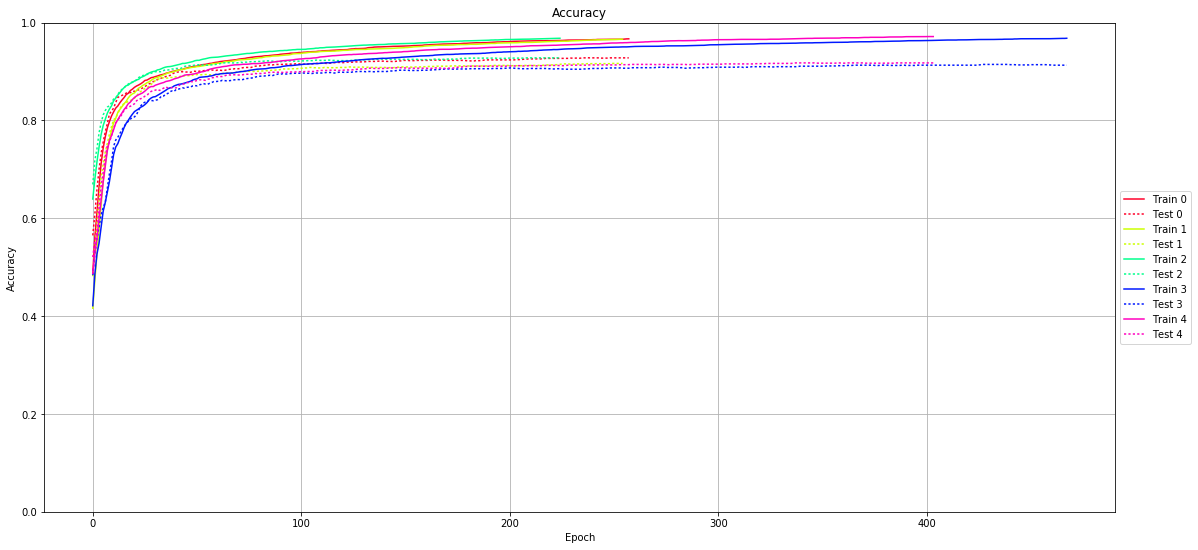

In [14]:
plot_acc(history)

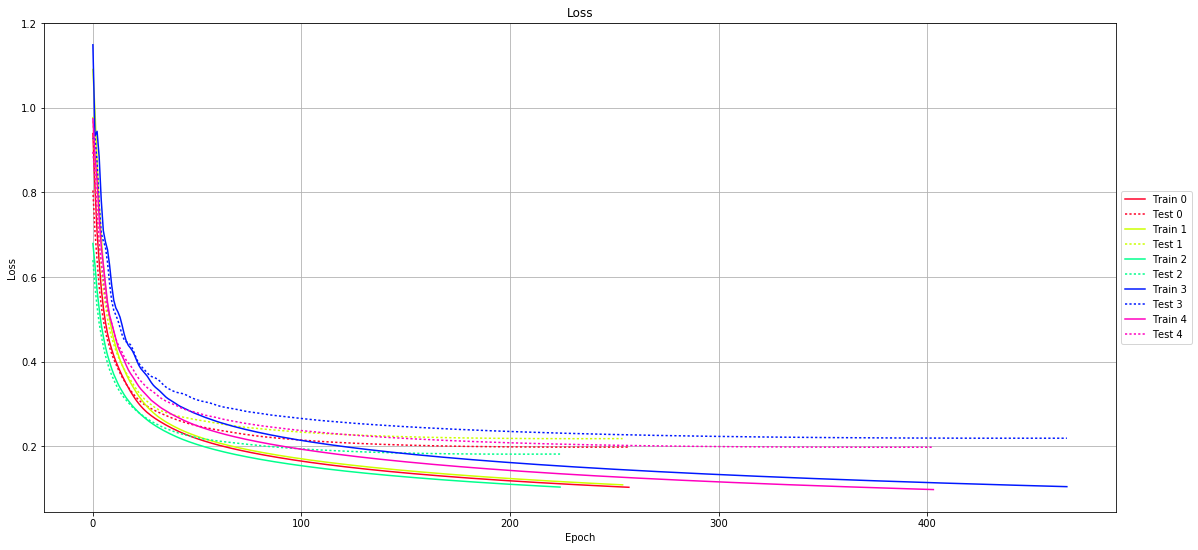

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


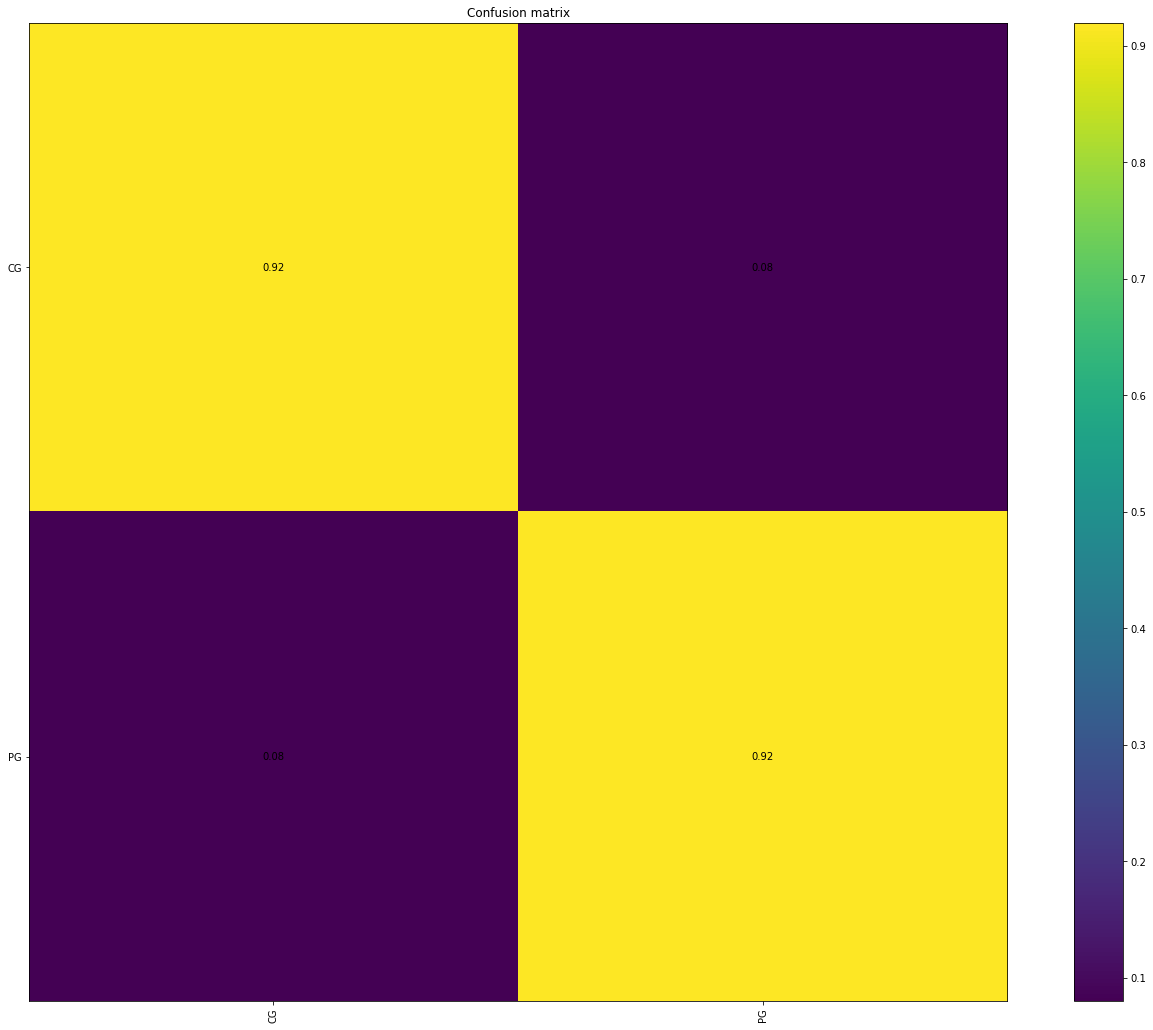

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()